In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nllgrid import NLLGrid
import geopandas as gpd


In [2]:
# Cargar el shapefile
gdf = gpd.read_file('extent.shp')

# Verificar el sistema de coordenadas
print(gdf.crs)

EPSG:4326


In [3]:
# Verificar si la proyección es geográfica y convertir si es necesario
if gdf.crs.is_geographic:
    gdf = gdf.to_crs(epsg=3857)
    print("Shapefile convertido a proyección Mercator.")
else:
    print("El shapefile ya está en una proyección proyectada.")

Shapefile convertido a proyección Mercator.


In [4]:
# Obtener el bounding box (caja envolvente) del polígono
polygon = gdf.geometry.iloc[0]
minx, miny, maxx, maxy = polygon.bounds

print(f"minx: {minx}, miny: {miny}")

# Calcular el tamaño del rectángulo en metros
length_x = maxx - minx
length_y = maxy - miny

# Calcular el número de elementos en x y en y
elements_x = int(length_x // 1000)
elements_y = int(length_y // 1000)

max_elements = max(elements_x, elements_y)

print(f"Elementos en x: {elements_x}, Elementos en y: {elements_y}")

minx: -11669823.762683755, miny: 3583642.4713136116
Elementos en x: 218, Elementos en y: 255


In [5]:
max_elements

255

In [6]:
nx = max_elements
ny = max_elements
nz = max_elements   # Dimensiones de la cuadrícula
x_orig, y_orig, z_orig = 0, 0, 0  # Origen de la cuadrícula
dx, dy, dz = 1000, 1000, 1000  # Espaciado de la cuadrícula

# Crear el objeto NLLGrid
gridp = NLLGrid(
    nx=nx, ny=ny, nz=nz,
    dx=dx, dy=dy, dz=dz,
    x_orig=x_orig, y_orig=y_orig, z_orig=z_orig
)


In [9]:
# Definir los valores de Vs para las capas
import numpy as np

# Supongamos que tienes una instancia de NLLGrid llamada grid
# Suponiendo que grid es una instancia de NLLGrid
gridp = NLLGrid(nx=nx, ny=ny, nz=nz)  # Inicializa grid con los tamaños deseados
gridp.init_array()  # Inicializa el array tridimensional con ceros


vp_values = [5.5, 5.85, 6.5, 8.18]  # Ejemplo de valores Vs

vs_values = [3.06,3.25, 3.61, 4.54]


# Asignar directamente los espesores de cada capa
layer_thickness = [5, 24, 10, 100]  # Espesor de cada capa en número de elementos en z

# Verificar que el número de espesores coincida con el número de Vs values
if len(layer_thickness) != len(vp_values):
    raise ValueError("La longitud de layer_thickness debe coincidir con la de vs_values")

# Asignar valores de Vs a cada capa en la dirección z
z_start = 0
for i, vs in enumerate(vp_values):
    z_end = z_start + layer_thickness[i]
    gridp.array[:, :, z_start:z_end] = vs
    z_start = z_end  # Actualizar z_start para la siguiente capa
if z_end < nz:
    gridp.array[:, :, z_end:] = vp_values[-1]

In [10]:

grids = NLLGrid(nx=nx, ny=ny, nz=nz)  # Inicializa grid con los tamaños deseados
grids.init_array()  # Inicializa el array tridimensional con ceros

if len(layer_thickness) != len(vs_values):
    raise ValueError("La longitud de layer_thickness debe coincidir con la de vs_values")

# Asignar valores de Vs a cada capa en la dirección z
z_start = 0
for i, vs in enumerate(vs_values):
    z_end = z_start + layer_thickness[i]
    grids.array[:, :, z_start:z_end] = vs
    z_start = z_end  # Actualizar z_start para la siguiente capa
if z_end < nz:
    grids.array[:, :, z_end:] = vs_values[-1]

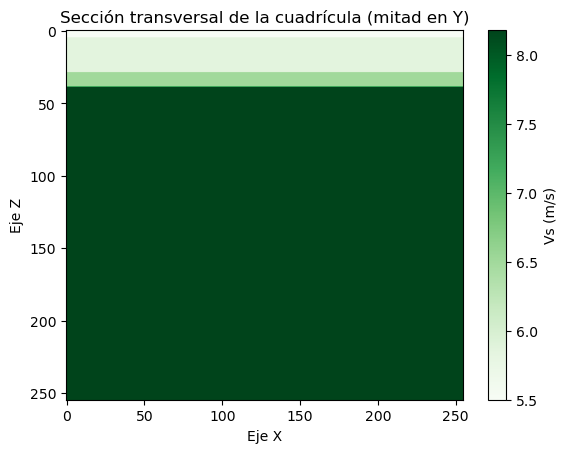

In [12]:
slice_index = ny // 2  # Tomar una rebanada en la mitad de la cuadrícula a lo largo del eje Y
plt.imshow(gridp.array[:, slice_index, :].T, cmap='Greens', origin='upper', aspect='auto')
plt.colorbar(label='Vs (m/s)')
plt.title('Sección transversal de la cuadrícula (mitad en Y)')
plt.xlabel('Eje X')
plt.ylabel('Eje Z')
plt.show()

In [13]:
# Asegúrate de que el tipo flotante esté correctamente definido
gridp.float_type = 'FLOAT'  # O 'DOUBLE' si prefieres precisión doble

# Ahora guarda la cuadrícula en archivos .hdr y .buf
gridp.basename = 'Vp_grid'
gridp.write_hdr_file()
gridp.write_buf_file()

In [14]:
# Supongamos que tienes una instancia de NLLGrid llamada grid

# Acceder directamente al array de NumPy
new_velp = gridp.array
new_vels = grids.array
# Ahora numpy_array es un array de NumPy de 3 dimensiones
print(type(new_velp))  # Debería mostrar <class 'numpy.ndarray'>
print(new_velp.shape)  # Debería mostrar (270, 270, 270) si esa es la forma del grid

<class 'numpy.ndarray'>
(255, 255, 255)


In [16]:
np.save('vp.npy', new_velp)
np.save('vs.npy', new_vels)